<p style="font-size: 120%">In this notebook we perform model selection and evaluation.</p>

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score,classification_report, confusion_matrix,ConfusionMatrixDisplay, roc_auc_score, roc_curve
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn import svm
import pickle
from pickle import dump


Load the 3 datasets (all extracted features included).

In [2]:
X_train = pd.read_csv("../train_val_test_datasets/X_train.csv") 
X_val = pd.read_csv("../train_val_test_datasets/X_val.csv") 
X_test = pd.read_csv("../train_val_test_datasets/X_test.csv")

y_train = pd.read_csv("../train_val_test_datasets/y_train.csv") 
y_val = pd.read_csv("../train_val_test_datasets/y_val.csv")
y_test = pd.read_csv("../train_val_test_datasets/y_test.csv")

Choose selected features with respect to different methods. Define a file to save the classifiers results corresponding to the FS method.

In [3]:
results_file = r"../classifiers_results/feature_selection_rfe_results.txt"
selected_features_list = 'rfe.txt'
f = open(results_file, "w")

# Get selected features

Folder 'important_features' includes .txt files which contain the features that each feature selection method suggested. Use these .txt files and extract only the features they include.

In [4]:
selected_feats=[]
with open(r'../important_features/'+selected_features_list, 'r') as fp:
    for line in fp:
        x = line[:-1]
        selected_feats.append(x)

X_train = X_train[selected_feats] #extract only these features
X_val = X_val[selected_feats]
X_test = X_test[selected_feats]

In [5]:
print(f' {len(selected_feats)} features have been selected')

 84 features have been selected


# Model selection

<p style = "font-size: 120%">First of all we start by standardizing our datasets, using the mean and variance computed on the training set.<br> <br> Then, we perform grid search on the classifiers that have hyperparameters. In each iteration, we fit the classifier on the training set and compute the training set error. We test it against the validation set and report the result. At the end, we select the classifier that has the higher f1 value on the validation set and the difference between training and validation set error is the minimum. <br> We address the issues of underfitting and overfitting with this approach.</p> <br>

<p style = "font-size: 120%">The final reporting of the classifier performance is computed on the test set.</p>

<br>  <p style = "font-size: 120%">At the end, we compute the baseline performance using a Dummy classifier that uses the probability distribution of the positive and negative samples (of the training set) in order to make a prediction. We will see that our selected model got a significantly higher performance. However, a Dummy classifier doesn't always reflect the real difficulty of the problem and it is rather domain oriented. For example, in our case we augmented the positive samples, but in the real world the percentage of people who suffer from heart murmur is much less than 47%, which is what our training set consists of. The corresponding percentage in our test set is 24%, which is a bit more representative according to the real world case.<p>

In [6]:
scaler = StandardScaler()
s = scaler.fit(X_train)

X_train=scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

#dump(scaler, open('scaler.pkl', 'wb'))

In [7]:
def print_metrics(y_val,y_pred,f,classifier):
    f.write(f'{classifier} Precision: {precision_score(y_val,y_pred)}\n')
    f.write(f'{classifier} Recall: {recall_score(y_val,y_pred)}\n')
    f.write(f'{classifier} f1_score: {f1_score(y_val,y_pred)}\n')
    f.write(f'{classifier} Accuracy: {accuracy_score(y_val,y_pred)}\n')
    f.write('---------------------------------------------------------------------------\n')

# Logistic Regression

grid search for logistic regression <br>
<b>log_reg_models</b> list contains all the models created.

In [8]:
def logistic_regression(X_train, y_train,X_val, y_val ):    
    params = {'penalty' : ['l1', 'l2', 'none','elasticnet'], 
              'C' : [0.01, 0.1, 1, 10, 100, 1000] }

    log_reg_models = []
    for p in params['penalty']:
        for c in params['C']:
            l1_ratio = 0.1 if p == 'elasticnet' else None
            clf = LogisticRegression(penalty=p,C=c,random_state=0,max_iter=5000,solver='saga',l1_ratio=l1_ratio).fit(X_train, y_train) 

            y_pred_train = clf.predict(X_train)
            y_pred_val = clf.predict(X_val)

            f1_train = f1_score(y_train,y_pred_train)
            f1_val = f1_score(y_val,y_pred_val)

            log_reg_models.append((clf,f1_val,f1_train,abs(f1_val-f1_train)))
    return log_reg_models

In [9]:
log_reg_models = logistic_regression(X_train, y_train,X_val, y_val )

We set a theshold of 0.65 to the f1 value and then manually we select the model with the highest f1 value that does not suffer from overfitting.

In [10]:
for i in range(len(log_reg_models)):
    if log_reg_models[i][1] > 0.65:
        print(log_reg_models[i][1],log_reg_models[i][2],log_reg_models[i][3],i)
        
model_selected = log_reg_models[18][0]
print(model_selected)

0.676056338028169 0.766884531590414 0.09082819356224503 6
0.6575342465753425 0.7450110864745011 0.08747683989915855 18
LogisticRegression(C=0.01, l1_ratio=0.1, max_iter=5000, penalty='elasticnet',
                   random_state=0, solver='saga')


Use the selected model and evaluate it on the test set.

Test set metrics:
Precision: 0.6097560975609756
Recall: 0.8333333333333334
f1_score: 0.7042253521126761
Accuracy: 0.8306451612903226

Confusion matrix:


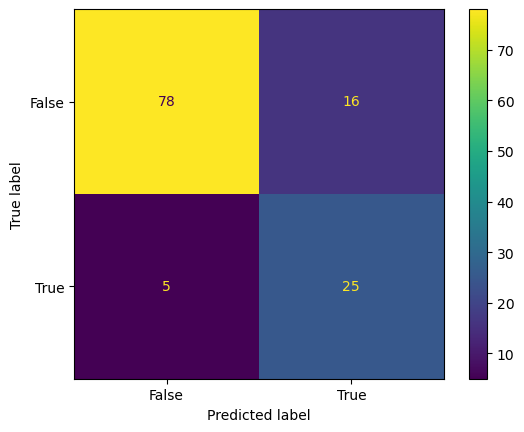

In [11]:
y_pred_test = model_selected.predict(X_test)

print('Test set metrics:')
print(f'Precision: {precision_score(y_test,y_pred_test)}')
print(f'Recall: {recall_score(y_test,y_pred_test)}')
print(f'f1_score: {f1_score(y_test,y_pred_test)}')
print(f'Accuracy: {accuracy_score(y_test,y_pred_test)}\n')
print(f'Confusion matrix:')

cm = confusion_matrix(y_test,y_pred_test)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])

cm_display.plot()
plt.show()

print_metrics(y_test,y_pred_test,f,"Logistic Regression")

# SVM

grid search for SVM <br>
<b>svm_models</b> list contains all the models created.

In [7]:
def svm_model(X_train, y_train,X_val, y_val ):    
    params = {'C' : [0.01, 0.1, 1, 10, 100, 1000],
             'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
             'gamma' : ['scale','auto'] }

    svm_models = []
    for c in params['C']:
        for k in params['kernel']:
            for g in params['gamma']:

                clf = svm.SVC(C=c,kernel=k,gamma=g,probability=True).fit(X_train, y_train) 

                y_pred_train = clf.predict(X_train)
                y_pred_val = clf.predict(X_val)

                f1_train = f1_score(y_train,y_pred_train)
                f1_val = f1_score(y_val,y_pred_val)

                svm_models.append((clf,f1_val,f1_train,abs(f1_val-f1_train)))
    return svm_models

In [13]:
svm_models = svm_model(X_train, y_train,X_val, y_val )

We set a theshold of 0.65 to the f1 value and then manually we select the model with the highest f1 value that does not suffer from overfitting.

In [14]:
for i in range(len(svm_models)):
    if svm_models[i][1] > 0.68:
        print(svm_models[i][1],svm_models[i][2],svm_models[i][3],i)
        
model_selected = svm_models[0][0]
print(model_selected)

0.6857142857142857 0.6901408450704225 0.004426559356136783 14
0.6857142857142857 0.6901408450704225 0.004426559356136783 15
SVC(C=0.01, kernel='linear', probability=True)


In [15]:
model_selected

SVC(C=0.01, kernel='linear', probability=True)

save the best model as a pickle file

In [16]:
#filename = 'final_model.pkl'
#pickle.dump(model_selected, open(filename, 'wb'))

<p style = "font-size: 120%">Given that the SVM above is the best model we got, we would like to see its probabilistic interpretation also and plot the corresponding roc curve. SVM does not have probabilities as output. It uses the sign() on the decision boundary to make predictions. What sklearn does here is that it gives as an input the linear part of the SVM hypothesis to a sigmoid function, as a linear combination of two parameters A and B that are defined using Maximum Likelihood Estimation.</p> 

Present Murmur AUC score: 0.8549645390070922


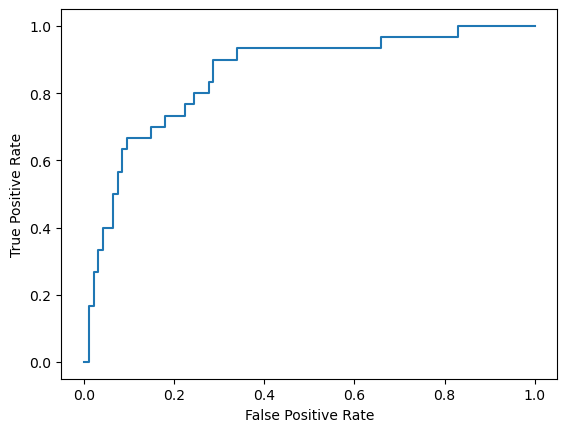

In [17]:
def plot_roc_curve(true_y, y_prob):
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

y_proba = model_selected.predict_proba(X_test)[:,1]
plot_roc_curve(y_test,y_proba)
print(f'Present Murmur AUC score: {roc_auc_score(y_test, y_proba)}')

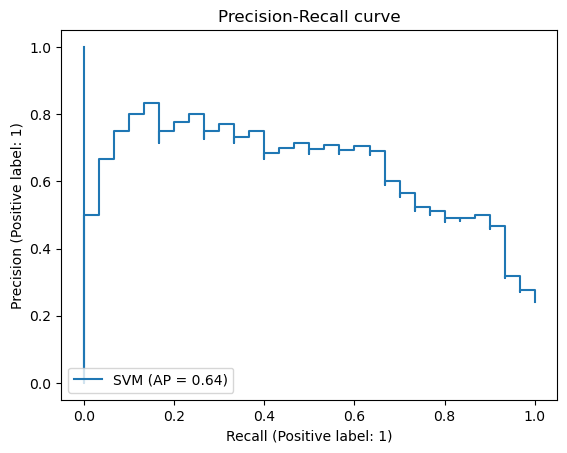

In [18]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    model_selected, X_test, y_test, name="SVM"
)
_ = display.ax_.set_title("Precision-Recall curve")

Final reporting of SVM 

Test set metrics:
Precision: 0.5526315789473685
Recall: 0.7
f1_score: 0.6176470588235295
Accuracy: 0.7903225806451613

Confusion matrix:


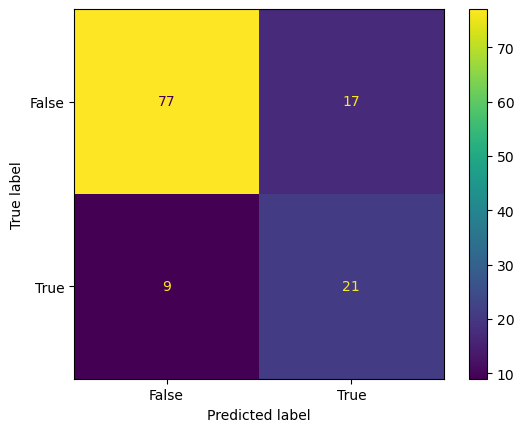

In [19]:
y_pred_test = model_selected.predict(X_test)

print('Test set metrics:')
print(f'Precision: {precision_score(y_test,y_pred_test)}')
print(f'Recall: {recall_score(y_test,y_pred_test)}')
print(f'f1_score: {f1_score(y_test,y_pred_test)}')
print(f'Accuracy: {accuracy_score(y_test,y_pred_test)}\n')
print(f'Confusion matrix:')

cm = confusion_matrix(y_test,y_pred_test)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])

cm_display.plot()
plt.show()

print_metrics(y_test,y_pred_test,f,"SVM")

# Naive Bayes

Train set metrics:
Precision: 0.6818181818181818
Recall: 0.7195571955719557
f1_score: 0.7001795332136445
Accuracy: 0.7365930599369085

Test set metrics:
Precision: 0.42857142857142855
Recall: 0.6
f1_score: 0.5
Accuracy: 0.7096774193548387



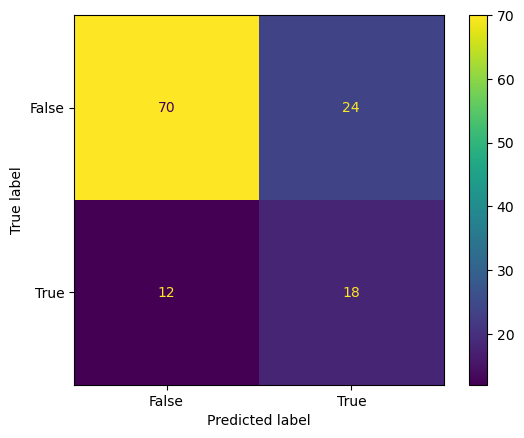

In [20]:
new_X_train = np.append(X_train,X_val,axis=0)
new_y_train = np.append(y_train,y_val,axis=0)

clf2 = GaussianNB()
clf2.fit(new_X_train, new_y_train)


y_train_pred  =  clf2.predict(new_X_train)
print('Train set metrics:')
print(f'Precision: {precision_score(new_y_train,y_train_pred)}')
print(f'Recall: {recall_score(new_y_train,y_train_pred)}')
print(f'f1_score: {f1_score(new_y_train,y_train_pred)}')
print(f'Accuracy: {accuracy_score(new_y_train,y_train_pred)}\n')

y_pred = clf2.predict(X_test)
print_metrics(y_test,y_pred,f,"Naive Bayes")

print('Test set metrics:')
print(f'Precision: {precision_score(y_test,y_pred)}')
print(f'Recall: {recall_score(y_test,y_pred)}')
print(f'f1_score: {f1_score(y_test,y_pred)}')
print(f'Accuracy: {accuracy_score(y_test,y_pred)}\n')




cm = confusion_matrix(y_test,y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])

cm_display.plot()
plt.show()

# KNN

Train set metrics:
Precision: 0.8522727272727273
Recall: 0.8302583025830258
f1_score: 0.8411214953271028
Accuracy: 0.8659305993690851

Test set metrics:
Precision: 0.48484848484848486
Recall: 0.5333333333333333
f1_score: 0.507936507936508
Accuracy: 0.75



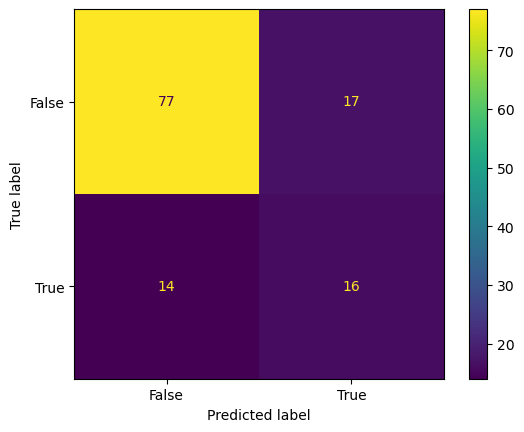

In [21]:
clf3 = KNeighborsClassifier(n_neighbors=5)
clf3.fit(new_X_train, new_y_train)


y_train_pred  =  clf3.predict(new_X_train)
print('Train set metrics:')
print(f'Precision: {precision_score(new_y_train,y_train_pred)}')
print(f'Recall: {recall_score(new_y_train,y_train_pred)}')
print(f'f1_score: {f1_score(new_y_train,y_train_pred)}')
print(f'Accuracy: {accuracy_score(new_y_train,y_train_pred)}\n')

y_pred = clf3.predict(X_test)


print('Test set metrics:')
print(f'Precision: {precision_score(y_test,y_pred)}')
print(f'Recall: {recall_score(y_test,y_pred)}')
print(f'f1_score: {f1_score(y_test,y_pred)}')
print(f'Accuracy: {accuracy_score(y_test,y_pred)}\n')



print_metrics(y_test,y_pred,f,"KNN")

cm = confusion_matrix(y_test,y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])

cm_display.plot()
plt.show()

# Decision Tree

In [22]:
params = {'criterion' : ['gini', 'entropy', 'log_loss'],
         'splitter' : ['best', 'random'],
         'max_depth' : [10,50,100,200,500],
         'min_samples_split': [2,5,10,20,40],
         'min_samples_leaf': [1,5,10,20,50]}

tree_models = []
for c in params['criterion']:
    for s in params['splitter']:
        for md in params['max_depth']:
            for mss in params['min_samples_split']:
                for msl in params['min_samples_leaf']:
                    
                    clf = tree.DecisionTreeClassifier(criterion=c,splitter=s,max_depth=md,min_samples_split=mss,min_samples_leaf=msl).fit(X_train, y_train) 

                    y_pred_train = clf.predict(X_train)
                    y_pred_val = clf.predict(X_val)

                    f1_train = f1_score(y_train,y_pred_train)
                    f1_val = f1_score(y_val,y_pred_val)

                    tree_models.append((clf,f1_val,f1_train,abs(f1_val-f1_train)))


In [23]:
for i in range(len(tree_models)):
    if tree_models[i][1] >= 0.6:
        print(tree_models[i][1],tree_models[i][2],tree_models[i][3],i)
        
model_selected = tree_models[463][0]
print(model_selected)

0.6153846153846154 0.854736842105263 0.2393522267206476 151
0.6097560975609756 0.6995515695067266 0.089795471945751 198
0.6027397260273972 0.7264770240700219 0.12373729804262468 408
0.6024096385542169 0.8755364806866952 0.2731268421324783 436
0.6046511627906975 0.7092511013215859 0.10459993853088834 468
0.625 0.8309572301425663 0.20595723014256628 491
0.6588235294117647 0.6462167689161554 0.01260676049560927 709
DecisionTreeClassifier(criterion='entropy', max_depth=200, min_samples_leaf=20,
                       min_samples_split=10, splitter='random')


Test set metrics:
Precision: 0.5116279069767442
Recall: 0.7333333333333333
f1_score: 0.6027397260273971
Accuracy: 0.7661290322580645

Confusion matrix:


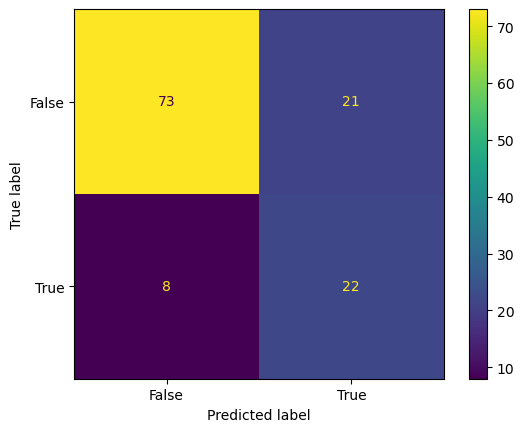

In [24]:
y_pred_test = model_selected.predict(X_test)

print('Test set metrics:')
print(f'Precision: {precision_score(y_test,y_pred_test)}')
print(f'Recall: {recall_score(y_test,y_pred_test)}')
print(f'f1_score: {f1_score(y_test,y_pred_test)}')
print(f'Accuracy: {accuracy_score(y_test,y_pred_test)}\n')
print(f'Confusion matrix:')

cm = confusion_matrix(y_test,y_pred_test)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])

cm_display.plot()
plt.show()

print_metrics(y_test,y_pred_test,f,"Decision Tree")

# LDA

Train set metrics:
Precision: 0.8443579766536965
Recall: 0.8007380073800738
f1_score: 0.8219696969696969
Accuracy: 0.8517350157728707

Test set metrics:
Precision: 0.45
Recall: 0.6
f1_score: 0.5142857142857143
Accuracy: 0.7258064516129032



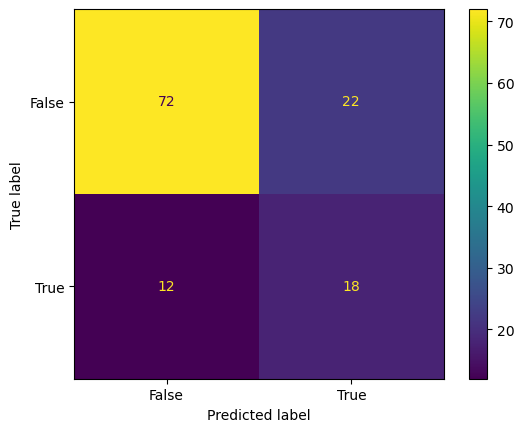

In [25]:
clf5 = LinearDiscriminantAnalysis()
clf5.fit(new_X_train, new_y_train)

y_train_pred  =  clf5.predict(new_X_train)
print('Train set metrics:')
print(f'Precision: {precision_score(new_y_train,y_train_pred)}')
print(f'Recall: {recall_score(new_y_train,y_train_pred)}')
print(f'f1_score: {f1_score(new_y_train,y_train_pred)}')
print(f'Accuracy: {accuracy_score(new_y_train,y_train_pred)}\n')

y_pred = clf5.predict(X_test)


print('Test set metrics:')
print(f'Precision: {precision_score(y_test,y_pred)}')
print(f'Recall: {recall_score(y_test,y_pred)}')
print(f'f1_score: {f1_score(y_test,y_pred)}')
print(f'Accuracy: {accuracy_score(y_test,y_pred)}\n')



print_metrics(y_test,y_pred,f,"LDA")
cm = confusion_matrix(y_test,y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])

cm_display.plot()
plt.show()

# QDA

Train set metrics:
Precision: 0.9813432835820896
Recall: 0.9704797047970479
f1_score: 0.9758812615955472
Accuracy: 0.9794952681388013

Test set metrics:
Precision: 0.4375
Recall: 0.23333333333333334
f1_score: 0.3043478260869565
Accuracy: 0.7419354838709677



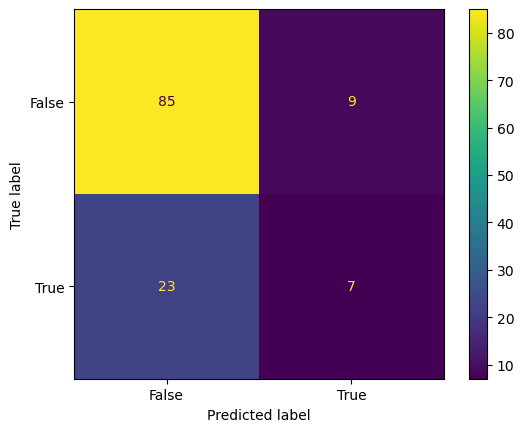

In [26]:
clf6 = QuadraticDiscriminantAnalysis()
clf6.fit(new_X_train, new_y_train)

y_train_pred  =  clf6.predict(new_X_train)
print('Train set metrics:')
print(f'Precision: {precision_score(new_y_train,y_train_pred)}')
print(f'Recall: {recall_score(new_y_train,y_train_pred)}')
print(f'f1_score: {f1_score(new_y_train,y_train_pred)}')
print(f'Accuracy: {accuracy_score(new_y_train,y_train_pred)}\n')

y_pred = clf6.predict(X_test)


print('Test set metrics:')
print(f'Precision: {precision_score(y_test,y_pred)}')
print(f'Recall: {recall_score(y_test,y_pred)}')
print(f'f1_score: {f1_score(y_test,y_pred)}')
print(f'Accuracy: {accuracy_score(y_test,y_pred)}\n')



print_metrics(y_test,y_pred,f,"QDA")

cm = confusion_matrix(y_test,y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])

cm_display.plot()
plt.show()

# ADABOOST

In [27]:
params = {'n_estimators' : [10, 50, 100],
         'learning_rate' : [0.1, 0.5, 0.8, 1.0],
         'algorithm' : ['SAMME','SAMME.R'] }

ada_models = []
for est in params['n_estimators']:
    for lr in params['learning_rate']:
        for a in params['algorithm']:
        
            clf = AdaBoostClassifier(n_estimators=est, random_state=0, learning_rate=lr, algorithm=a).fit(X_train, y_train)
       
            y_pred_train = clf.predict(X_train)
            y_pred_val = clf.predict(X_val)

            f1_train = f1_score(y_train,y_pred_train)
            f1_val = f1_score(y_val,y_pred_val)

            ada_models.append((clf,f1_val,f1_train,abs(f1_val-f1_train)))


In [28]:
for i in range(len(ada_models)):
    if ada_models[i][1] > 0.6:
        print(ada_models[i][1],ada_models[i][2],ada_models[i][3],i)
        
model_selected = ada_models[22][0]
print(model_selected)

0.6578947368421053 0.9617021276595743 0.303807390817469 19
0.6419753086419753 0.8961038961038962 0.2541285874619209 20
0.6052631578947368 0.9957805907172996 0.3905174328225628 21
0.6753246753246752 0.9316239316239316 0.25629925629925643 22
0.6075949367088608 0.9978947368421053 0.3902998001332445 23
AdaBoostClassifier(algorithm='SAMME', n_estimators=100, random_state=0)


Test set metrics:
Precision: 0.5581395348837209
Recall: 0.8
f1_score: 0.6575342465753425
Accuracy: 0.7983870967741935

Confusion matrix:


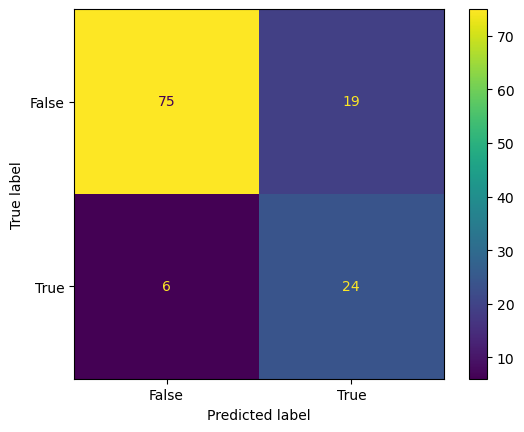

In [29]:
y_pred_test = model_selected.predict(X_test)

print('Test set metrics:')
print(f'Precision: {precision_score(y_test,y_pred_test)}')
print(f'Recall: {recall_score(y_test,y_pred_test)}')
print(f'f1_score: {f1_score(y_test,y_pred_test)}')
print(f'Accuracy: {accuracy_score(y_test,y_pred_test)}\n')
print(f'Confusion matrix:')

cm = confusion_matrix(y_test,y_pred_test)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])

cm_display.plot()
plt.show()

print_metrics(y_test,y_pred_test,f,"ADABOOST")

In [30]:
f.close()

# Baseline performance using DummyClassifier

Precision: 0.2777777777777778
Recall: 0.5
f1_score: 0.35714285714285715
Accuracy: 0.5645161290322581


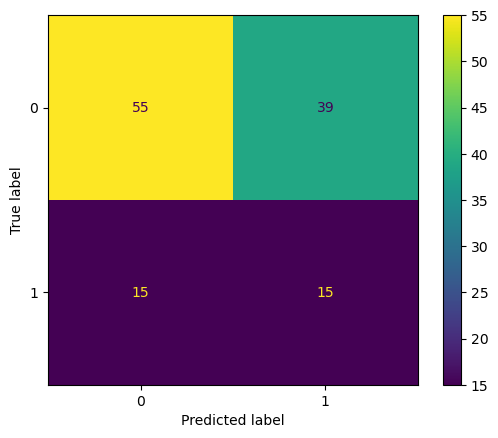

In [31]:
from sklearn.dummy import DummyClassifier

clf_dummy = DummyClassifier(strategy='stratified').fit(X_train, y_train)
y_pred = clf_dummy.predict(X_test)

print(f'Precision: {precision_score(y_test,y_pred)}')
print(f'Recall: {recall_score(y_test,y_pred)}')
print(f'f1_score: {f1_score(y_test,y_pred)}')
print(f'Accuracy: {accuracy_score(y_test,y_pred)}')

cm = confusion_matrix(y_test,y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm)

cm_display.plot()
plt.show()

# Use only one of the 4 examination areas

In [9]:
X_train = pd.read_csv("../train_val_test_datasets/X_train.csv") 
X_val = pd.read_csv("../train_val_test_datasets/X_val.csv") 
X_test = pd.read_csv("../train_val_test_datasets/X_test.csv")

y_train = pd.read_csv("../train_val_test_datasets/y_train.csv") 
y_val = pd.read_csv("../train_val_test_datasets/y_val.csv")
y_test = pd.read_csv("../train_val_test_datasets/y_test.csv")

In [10]:
AV_columns = [ col for col in X_train.columns if col.startswith('AV') or col.endswith('AV')]
MV_columns = [ col for col in X_train.columns if col.startswith('MV') or col.endswith('MV')]
PV_columns = [ col for col in X_train.columns if col.startswith('PV') or col.endswith('PV')]
TV_columns = [ col for col in X_train.columns if col.startswith('TV') or col.endswith('TV')]

In [11]:
AV_X_train = X_train[AV_columns]
AV_X_val = X_val[AV_columns]
AV_X_test = X_test[AV_columns]

MV_X_train = X_train[MV_columns]
MV_X_val = X_val[MV_columns]
MV_X_test = X_test[MV_columns]

PV_X_train = X_train[PV_columns]
PV_X_val = X_val[PV_columns]
PV_X_test = X_test[PV_columns]


TV_X_train = X_train[TV_columns]
TV_X_val = X_val[TV_columns]
TV_X_test = X_test[TV_columns]

# Model selection based only on AV examination area

In [35]:
scaler = StandardScaler()
s = scaler.fit(AV_X_train)

AV_X_train=scaler.transform(AV_X_train)
AV_X_val = scaler.transform(AV_X_val)
AV_X_test = scaler.transform(AV_X_test)

# Logistic Regression

In [36]:
log_reg_models = logistic_regression(AV_X_train, y_train,AV_X_val, y_val )

0.5974025974025974 0.6414253897550112 0.0440227923524138 1
0.6052631578947368 0.6975717439293597 0.09230858603462289 2
0.5789473684210527 0.6993318485523385 0.12038448013128589 3
0.5789473684210527 0.7064017660044151 0.1274543975833624 4
0.5714285714285715 0.7108167770419427 0.13938820561337117 5
0.5822784810126582 0.6696035242290749 0.08732504321641665 7
0.6153846153846153 0.6830357142857143 0.067651098901099 8
0.5789473684210527 0.7022222222222221 0.12327485380116943 9
0.5789473684210527 0.7095343680709534 0.13058699964990073 10
0.5714285714285715 0.7108167770419427 0.13938820561337117 11
0.5714285714285715 0.7108167770419427 0.13938820561337117 12
0.5714285714285715 0.7108167770419427 0.13938820561337117 13
0.5714285714285715 0.7108167770419427 0.13938820561337117 14
0.5714285714285715 0.7108167770419427 0.13938820561337117 15
0.5714285714285715 0.7108167770419427 0.13938820561337117 16
0.5714285714285715 0.7108167770419427 0.13938820561337117 17
0.5945945945945946 0.615384615384615

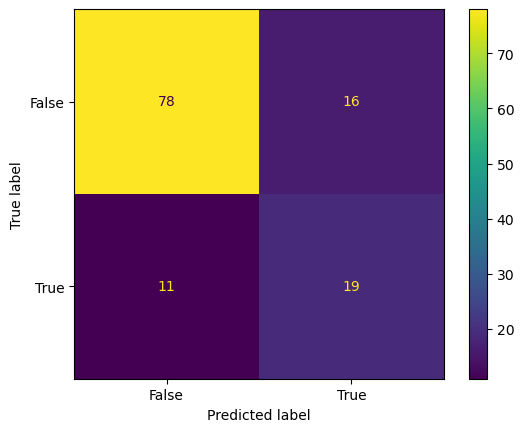

In [37]:
for i in range(len(log_reg_models)):
    if log_reg_models[i][1] > 0.55:
        print(log_reg_models[i][1],log_reg_models[i][2],log_reg_models[i][3],i)
        
model_selected = log_reg_models[20][0]
print(model_selected)

y_pred_test = model_selected.predict(AV_X_test)

print('Test set metrics:')
print(f'Precision: {precision_score(y_test,y_pred_test)}')
print(f'Recall: {recall_score(y_test,y_pred_test)}')
print(f'f1_score: {f1_score(y_test,y_pred_test)}')
print(f'Accuracy: {accuracy_score(y_test,y_pred_test)}\n')
print(f'Confusion matrix:')

cm = confusion_matrix(y_test,y_pred_test)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])

cm_display.plot()
plt.show()

# SVM

In [38]:
svm_models = svm_model(AV_X_train, y_train,AV_X_val, y_val  )

0.6133333333333334 0.6800894854586129 0.06675615212527952 16
0.6133333333333334 0.6800894854586129 0.06675615212527952 17
0.6153846153846153 0.7095343680709534 0.09414975268633807 40
0.6153846153846153 0.7095343680709534 0.09414975268633807 41
SVC(C=1, kernel='linear', probability=True)
Test set metrics:
Precision: 0.5405405405405406
Recall: 0.6666666666666666
f1_score: 0.5970149253731343
Accuracy: 0.782258064516129

Confusion matrix:


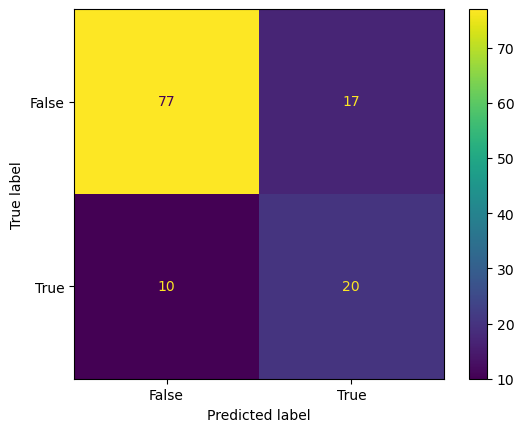

In [39]:
for i in range(len(svm_models)):
    if svm_models[i][1] > 0.6:
        print(svm_models[i][1],svm_models[i][2],svm_models[i][3],i)
        
model_selected = svm_models[16][0]
print(model_selected)

y_pred_test = model_selected.predict(AV_X_test)

print('Test set metrics:')
print(f'Precision: {precision_score(y_test,y_pred_test)}')
print(f'Recall: {recall_score(y_test,y_pred_test)}')
print(f'f1_score: {f1_score(y_test,y_pred_test)}')
print(f'Accuracy: {accuracy_score(y_test,y_pred_test)}\n')
print(f'Confusion matrix:')

cm = confusion_matrix(y_test,y_pred_test)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])

cm_display.plot()
plt.show()


# Model selection based only on MV examination area

In [40]:
scaler = StandardScaler()
s = scaler.fit(MV_X_train)

MV_X_train=scaler.transform(MV_X_train)
MV_X_val = scaler.transform(MV_X_val)
MV_X_test = scaler.transform(MV_X_test)

# Logistic Regression

In [41]:
log_reg_models = logistic_regression(MV_X_train, y_train,MV_X_val, y_val )

LogisticRegression(C=1, l1_ratio=0.1, max_iter=5000, penalty='elasticnet',
                   random_state=0, solver='saga')
Test set metrics:
Precision: 0.4222222222222222
Recall: 0.6333333333333333
f1_score: 0.5066666666666666
Accuracy: 0.7016129032258065

Confusion matrix:


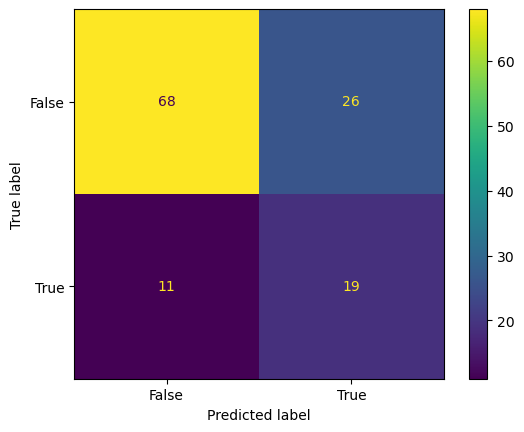

In [42]:
for i in range(len(log_reg_models)):
    if log_reg_models[i][1] > 0.55:
        print(log_reg_models[i][1],log_reg_models[i][2],log_reg_models[i][3],i)
        
model_selected = log_reg_models[20][0]
print(model_selected)

y_pred_test = model_selected.predict(MV_X_test)

print('Test set metrics:')
print(f'Precision: {precision_score(y_test,y_pred_test)}')
print(f'Recall: {recall_score(y_test,y_pred_test)}')
print(f'f1_score: {f1_score(y_test,y_pred_test)}')
print(f'Accuracy: {accuracy_score(y_test,y_pred_test)}\n')
print(f'Confusion matrix:')

cm = confusion_matrix(y_test,y_pred_test)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])

cm_display.plot()
plt.show()

# SVM

In [43]:
svm_models = svm_model(MV_X_train, y_train,MV_X_val, y_val  )

SVC(C=0.1, kernel='sigmoid', probability=True)
Test set metrics:
Precision: 0.46153846153846156
Recall: 0.6
f1_score: 0.5217391304347826
Accuracy: 0.7338709677419355

Confusion matrix:


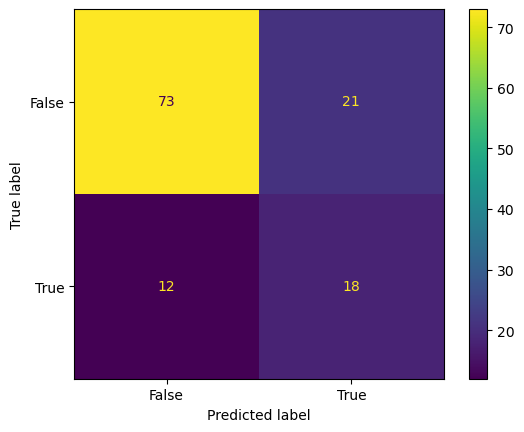

In [44]:
for i in range(len(svm_models)):
    if svm_models[i][1] > 0.65:
        print(svm_models[i][1],svm_models[i][2],svm_models[i][3],i)
        
model_selected = svm_models[14][0]
print(model_selected)

y_pred_test = model_selected.predict(MV_X_test)

print('Test set metrics:')
print(f'Precision: {precision_score(y_test,y_pred_test)}')
print(f'Recall: {recall_score(y_test,y_pred_test)}')
print(f'f1_score: {f1_score(y_test,y_pred_test)}')
print(f'Accuracy: {accuracy_score(y_test,y_pred_test)}\n')
print(f'Confusion matrix:')

cm = confusion_matrix(y_test,y_pred_test)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])

cm_display.plot()
plt.show()



# Model selection based only on PV examination area

In [45]:
scaler = StandardScaler()
s = scaler.fit(PV_X_train)

PV_X_train=scaler.transform(PV_X_train)
PV_X_val = scaler.transform(PV_X_val)
PV_X_test = scaler.transform(PV_X_test)

In [46]:
log_reg_models = logistic_regression(PV_X_train, y_train,PV_X_val, y_val )

0.5675675675675675 0.7032967032967032 0.1357291357291357 19
LogisticRegression(C=1, l1_ratio=0.1, max_iter=5000, penalty='elasticnet',
                   random_state=0, solver='saga')
Test set metrics:
Precision: 0.5
Recall: 0.7
f1_score: 0.5833333333333334
Accuracy: 0.7580645161290323

Confusion matrix:


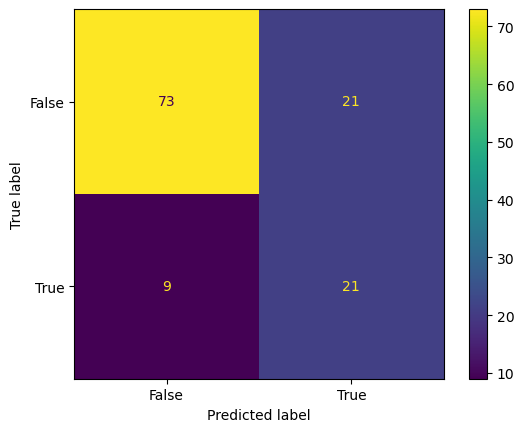

In [47]:
for i in range(len(log_reg_models)):
    if log_reg_models[i][1] > 0.55:
        print(log_reg_models[i][1],log_reg_models[i][2],log_reg_models[i][3],i)
        
model_selected = log_reg_models[20][0]
print(model_selected)

y_pred_test = model_selected.predict(PV_X_test)

print('Test set metrics:')
print(f'Precision: {precision_score(y_test,y_pred_test)}')
print(f'Recall: {recall_score(y_test,y_pred_test)}')
print(f'f1_score: {f1_score(y_test,y_pred_test)}')
print(f'Accuracy: {accuracy_score(y_test,y_pred_test)}\n')
print(f'Confusion matrix:')

cm = confusion_matrix(y_test,y_pred_test)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])

cm_display.plot()
plt.show()



# SVM

In [51]:
svm_models = svm_model(PV_X_train, y_train,PV_X_val, y_val  )

SVC(C=0.1, kernel='sigmoid', probability=True)
Test set metrics:
Precision: 0.6363636363636364
Recall: 0.4666666666666667
f1_score: 0.5384615384615385
Accuracy: 0.8064516129032258

Confusion matrix:


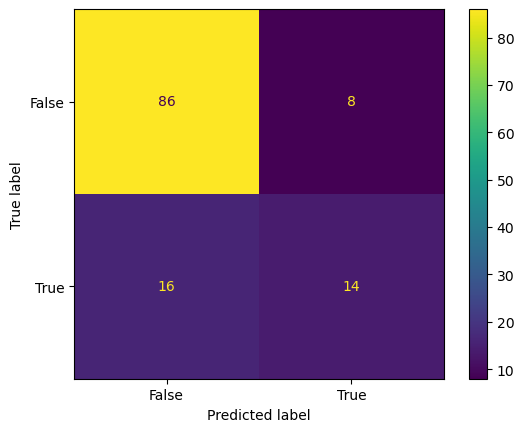

In [52]:
for i in range(len(svm_models)):
    if svm_models[i][1] > 0.55:
        print(svm_models[i][1],svm_models[i][2],svm_models[i][3],i)
        
model_selected = svm_models[14][0]
print(model_selected)

y_pred_test = model_selected.predict(PV_X_test)

print('Test set metrics:')
print(f'Precision: {precision_score(y_test,y_pred_test)}')
print(f'Recall: {recall_score(y_test,y_pred_test)}')
print(f'f1_score: {f1_score(y_test,y_pred_test)}')
print(f'Accuracy: {accuracy_score(y_test,y_pred_test)}\n')
print(f'Confusion matrix:')

cm = confusion_matrix(y_test,y_pred_test)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])

cm_display.plot()
plt.show()



# Model selection based only on TV examination area

In [12]:
scaler = StandardScaler()
s = scaler.fit(TV_X_train)

PV_X_train=scaler.transform(TV_X_train)
PV_X_val = scaler.transform(TV_X_val)
PV_X_test = scaler.transform(TV_X_test)

In [54]:
log_reg_models = logistic_regression(TV_X_train, y_train,TV_X_val, y_val )

0.6097560975609756 0.5895691609977324 0.02018693656324322 0
0.6046511627906975 0.6018099547511312 0.002841208039566334 1
0.6046511627906975 0.6063348416289592 0.001683678838261704 2
0.6046511627906975 0.6063348416289592 0.001683678838261704 3
0.6046511627906975 0.6063348416289592 0.001683678838261704 4
0.6046511627906975 0.6063348416289592 0.001683678838261704 5
0.6046511627906975 0.6063348416289592 0.001683678838261704 6
0.6046511627906975 0.6063348416289592 0.001683678838261704 7
0.6046511627906975 0.6063348416289592 0.001683678838261704 8
0.6046511627906975 0.6063348416289592 0.001683678838261704 9
0.6046511627906975 0.6063348416289592 0.001683678838261704 10
0.6046511627906975 0.6063348416289592 0.001683678838261704 11
0.6046511627906975 0.6063348416289592 0.001683678838261704 12
0.6046511627906975 0.6063348416289592 0.001683678838261704 13
0.6046511627906975 0.6063348416289592 0.001683678838261704 14
0.6046511627906975 0.6063348416289592 0.001683678838261704 15
0.6046511627906975 

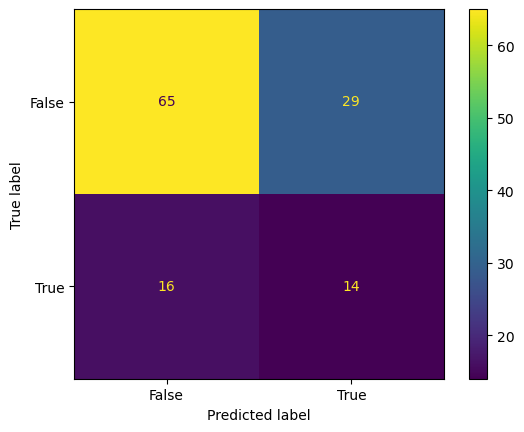

In [55]:
for i in range(len(log_reg_models)):
    if log_reg_models[i][1] > 0.55:
        print(log_reg_models[i][1],log_reg_models[i][2],log_reg_models[i][3],i)
        
model_selected = log_reg_models[20][0]
print(model_selected)

y_pred_test = model_selected.predict(TV_X_test)

print('Test set metrics:')
print(f'Precision: {precision_score(y_test,y_pred_test)}')
print(f'Recall: {recall_score(y_test,y_pred_test)}')
print(f'f1_score: {f1_score(y_test,y_pred_test)}')
print(f'Accuracy: {accuracy_score(y_test,y_pred_test)}\n')
print(f'Confusion matrix:')

cm = confusion_matrix(y_test,y_pred_test)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])

cm_display.plot()
plt.show()



# SVM

In [ ]:
svm_models = svm_model(TV_X_train, y_train,TV_X_val, y_val  )

In [ ]:
for i in range(len(svm_models)):
    if svm_models[i][1] > 0.55:
        print(svm_models[i][1],svm_models[i][2],svm_models[i][3],i)
        
model_selected = svm_models[14][0]
print(model_selected)

y_pred_test = model_selected.predict(TV_X_test)

print('Test set metrics:')
print(f'Precision: {precision_score(y_test,y_pred_test)}')
print(f'Recall: {recall_score(y_test,y_pred_test)}')
print(f'f1_score: {f1_score(y_test,y_pred_test)}')
print(f'Accuracy: {accuracy_score(y_test,y_pred_test)}\n')
print(f'Confusion matrix:')

cm = confusion_matrix(y_test,y_pred_test)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])

cm_display.plot()
plt.show()

